# ENSO Analysis in ARISE

Imports

In [1]:
import numpy as np
import xarray as xr
import cftime 
import matplotlib.pyplot as plt
from scipy import signal
import cartopy
import cartopy.crs as ccrs

c:\Users\Heather\anaconda3\envs\SAI_proj\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Functions

In [28]:
def time_addition(ds):

    ds_time = xr.cftime_range(
        start=ds.time.units.split('months since ')[1],
        periods=(ds.TIME.shape[0] * 12),
        freq='M', calendar='noleap')

    ds['time'] = ds_time.to_datetimeindex()

    return ds


def make_landmask():

    ds001 = xr.open_dataset(
        'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData002/ARISEData/ARISECTL001.cvdp_data.2015-2035.nc',
        decode_times=False)

    landmask = xr.where(
        np.isnan(ds001['amv_prime_pattern_mon']), 1, np.nan).values

    return landmask


def assemble_dataarray(filelist, variable_string):

    dict_ = {}

    for num, i in enumerate(filelist):

        try:
            dict_[num] = time_addition(
                xr.open_dataset(i, decode_times=False))[variable_string]

        except KeyError:
            continue

    dict_array = xr.concat([
        dict_[0], dict_[1], dict_[2], dict_[3], dict_[4], dict_[5],
        dict_[6], dict_[7], dict_[8], dict_[9],
    ], dim='ensemble')

    return dict_array


def detrend_enso_timeseries(filelist, variable):
    """
    Detrend ENSO timeseries for index.
    
    Variables:
        filename = str
        variable = str
    """
    
    dict_ = {}

    for num, i in enumerate(filelist):

        try:
            
            ds_detrended = signal.detrend(
                # convert time
                time_addition(
                    # open file
                    xr.open_dataset(
                        i, decode_cf=False))[variable], axis=- 1, 
                type='linear', bp=0, overwrite_data=False)

            newtime = time_addition(
                xr.open_dataset(
                    i, decode_cf=False))[variable].time.data

            dict_indv = xr.Dataset(
                data_vars=dict(data=(["time"], ds_detrended)),
                coords=dict(time=newtime))
            
            dict_[num] = dict_indv

        except KeyError:
            continue
    
    return dict_


def get_enso_events(filelist, variable):
    """
    Get ENSO events based on detrended anomaly magnitude.
    """
    
    if variable.split('_')[1] == 'elnino':
        tmp_var = 'number_of_elnino_events'
        set_pac_temp = 'warm'

    elif variable.split('_')[1] == 'lanina':
        tmp_var = 'number_of_lanina_events'
        set_pac_temp = 'cold'
    
    dict_ = {}

    for num, i in enumerate(filelist):

        try:
            
            # number of enso events
            num_events = xr.open_dataset(
                i, decode_cf=False)[variable].attrs[tmp_var]
            
            # detrended nino34, all months time series
            ds_detrended = signal.detrend(
                time_addition(
                    xr.open_dataset(
                        i, decode_cf=False))['nino34'], axis=- 1, 
                type='linear', bp=0, overwrite_data=False)

            # create time array 
            newtime = time_addition(
                xr.open_dataset(
                    i, decode_cf=False))['nino34'].time.data

            # create dataset of detrended file with time
            dict_indv = xr.Dataset(
                data_vars=dict(data=(["time"], ds_detrended)),
                coords=dict(time=newtime))
            
            # data array of november months
            da_dec = dict_indv.data[(dict_indv.time.dt.month.values==12)]
            
            if set_pac_temp == 'warm':
                dict_[num] = da_dec.to_dataset().sortby('data', ascending=False).data[:num_events]
                
            if set_pac_temp == 'cold':
                dict_[num] = da_dec.to_dataset().sortby('data', ascending=True).data[:num_events]
                
        except KeyError:
            continue
    
    return dict_


def get_total_enso_events(filelist, variable):
    """
    Get the frequency of ENSO events.
    """
    
    if variable.split('_')[1] == 'elnino':
        tmp_var = 'number_of_elnino_events'

    elif variable.split('_')[1] == 'lanina':
        tmp_var = 'number_of_lanina_events'

    list_of_events = []
        
    for num, i in enumerate(filelist):

        try:
            
            # number of enso events
            num_events = xr.open_dataset(
                i, decode_cf=False)[variable].attrs[tmp_var]
            
            list_of_events.append(num_events)
                
        except KeyError:
            continue
    
    return list_of_events

### set variables and filelists

In [29]:
# variables of interest

ts_nina = 'nino34_lanina_spacomp_tas_djf1'
ts_nino = 'nino34_elnino_spacomp_tas_djf1'

In [2]:
files_ARISECTL = [
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData002/ARISEData/ARISECTL001.cvdp_data.2015-2035.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISECTL002.cvdp_data.2015-2035.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISECTL003.cvdp_data.2015-2035.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISECTL004.cvdp_data.2015-2035.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISECTL005.cvdp_data.2015-2035.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISECTL006.cvdp_data.2015-2035.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISECTL007.cvdp_data.2015-2035.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISECTL008.cvdp_data.2015-2035.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISECTL009.cvdp_data.2015-2035.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData002/ARISEData/ARISECTL010.cvdp_data.2015-2035.nc',
]

files_ARISESAI = [
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI001.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI002.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI003.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI004.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI005.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI006.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI007.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI008.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI009.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI010.cvdp_data.2035-2069.nc',
]

files_WACCMENS = [
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245001.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245002.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245003.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245004.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245005.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245006.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245007.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245008.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245009.cvdp_data.2035-2069.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245010.cvdp_data.2035-2069.nc',
]

In [35]:
xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245010.cvdp_data.2035-2069.nc',decode_times=False)

<xarray.Dataset>
Dimensions:                               (TIME: 35, lat: 192, lon: 288, ncurves: 4, frequency: 210, time: 420, j: 384, i: 320, j2: 384, i2: 320, longitude: 129, time_mon3: 49, time_mon1: 29, time_mon2: 12, period: 105)
Coordinates: (12/15)
  * TIME                                  (TIME) int32 2035 2036 ... 2068 2069
  * frequency                             (frequency) float32 0.002381 ... 0.5
  * lat                                   (lat) float64 -90.0 -89.06 ... 90.0
    lat2d_ice_nh                          (j, i) float32 ...
    lat2d_ice_sh                          (j2, i2) float32 ...
  * lon                                   (lon) float64 0.0 1.25 ... 357.5 358.8
    ...                                    ...
  * ncurves                               (ncurves) int32 0 1 2 3
  * period                                (period) float32 0.08609 ... 34.98
  * time                                  (time) float32 0.0 1.0 ... 418.0 419.0
  * time_mon1                             (time_mon1) int32 0 1 2 3 ... 26 27 28
  * time_mon2                             (time_mon2) int32 0 1 2 3 ... 9 10 11
  * time_mon3                             (time_mon3) int32 0 1 2 3 ... 46 47 48
Dimensions without coordinates: j, i, j2, i2
Data variables: (12/395)
    amv_pattern_lowpass_mon               (lat, lon) float32 ...
    amv_pattern_mon                       (lat, lon) float32 ...
    amv_pr_regression_lowpass_mon         (lat, lon) float32 ...
    amv_pr_regression_mon                 (lat, lon) float32 ...
    amv_prime_pattern_lowpass_mon         (lat, lon) float32 ...
    amv_prime_pattern_mon                 (lat, lon) float32 ...
    ...                                    ...
    tas_trends_jas                        (lat, lon) float32 ...
    tas_trends_jfm                        (lat, lon) float32 ...
    tas_trends_jja                        (lat, lon) float32 ...
    tas_trends_mam                        (lat, lon) float32 ...
    tas_trends_son                        (lat, lon) float32 ...
    tropical_indian_ocean                 (time) float32 ...
Attributes:
    source:       NCAR Climate Analysis Section's Climate Variability Diagnos...
    notes:        Data from WACCM245010 Ensemble Mean from 2035-2069
    climatology:  2035-2069 climatology removed prior to all calculations (ot...
    Conventions:  CF-1.6
    history:      Mon Sep 19 23:19:52 2022: ncks -O ./output/WACCM245010.cvdp...
    NCO:          "4.5.2"

In [35]:
# make landmask
landmask = make_landmask()

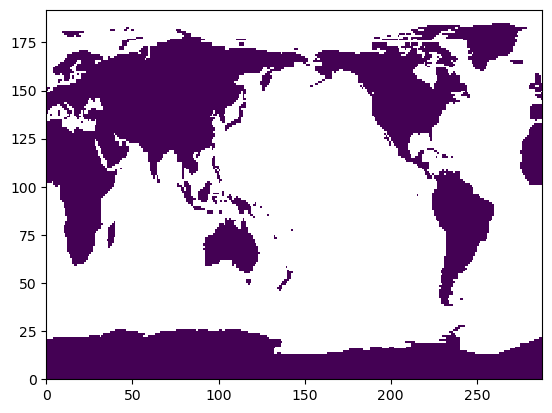

In [36]:
plt.pcolormesh(landmask); plt.show()

# Nino

In [31]:
#import pandas as pd
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
arise_ctl_ts_nino = assemble_dataarray(files_ARISECTL, ts_nino)
arise_ctl_ts_nino_events = get_enso_events(files_ARISECTL, ts_nino)
arise_ctl_ts_nino_freq = np.sum(get_total_enso_events(files_ARISECTL, ts_nino))

arise_sai_ts_nino = assemble_dataarray(files_ARISESAI, ts_nino)
arise_sai_ts_nino_events = get_enso_events(files_ARISESAI, ts_nino)
arise_sai_ts_nino_freq = np.sum(get_total_enso_events(files_ARISESAI, ts_nino))

waccm_sai_ts_nino = assemble_dataarray(files_WACCMENS, ts_nino)
waccm_sai_ts_nino_events = get_enso_events(files_WACCMENS, ts_nino)
waccm_sai_ts_nino_freq = np.sum(get_total_enso_events(files_WACCMENS, ts_nino))

C:\Users\Heather\AppData\Local\Temp\ipykernel_23660\330342055.py:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = ds_time.to_datetimeindex()


In [32]:
arise_ctl_ts_nina = assemble_dataarray(files_ARISECTL, ts_nina)
arise_ctl_ts_nina_events = get_enso_events(files_ARISECTL, ts_nina)
arise_ctl_ts_nina_freq = np.sum(get_total_enso_events(files_ARISECTL, ts_nina))

arise_sai_ts_nina = assemble_dataarray(files_ARISESAI, ts_nina)
arise_sai_ts_nina_events = get_enso_events(files_ARISESAI, ts_nina)
arise_sai_ts_nina_freq = np.sum(get_total_enso_events(files_ARISESAI, ts_nina))

waccm_sai_ts_nina = assemble_dataarray(files_WACCMENS, ts_nina)
waccm_sai_ts_nina_events = get_enso_events(files_WACCMENS, ts_nina)
waccm_sai_ts_nina_freq = np.sum(get_total_enso_events(files_WACCMENS, ts_nina))

C:\Users\Heather\AppData\Local\Temp\ipykernel_23660\330342055.py:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = ds_time.to_datetimeindex()


In [37]:
lats = arise_ctl_ts_nino.lat
lons = arise_ctl_ts_nino.lon

arise_ctl_ts_nino_vals = arise_ctl_ts_nino.mean('ensemble', skipna=True).where(landmask == 1).values
arise_sai_ts_nino_vals = arise_sai_ts_nino.mean('ensemble', skipna=True).where(landmask == 1).values
waccm_sai_ts_nino_vals = waccm_sai_ts_nino.mean('ensemble', skipna=True).where(landmask == 1).values
future_diff_nino_vals = (xr.where(waccm_sai_ts_nino > 0, 1, -1).sum('ensemble', skipna=True) - xr.where(
    arise_sai_ts_nino > 0, 1, -1).sum('ensemble', skipna=True)).where(landmask == 1).values

arise_ctl_ts_nina_vals = arise_ctl_ts_nina.mean('ensemble', skipna=True).where(landmask == 1).values
arise_sai_ts_nina_vals = arise_sai_ts_nina.mean('ensemble', skipna=True).where(landmask == 1).values
waccm_sai_ts_nina_vals = waccm_sai_ts_nina.mean('ensemble', skipna=True).where(landmask == 1).values
future_diff_nina_vals = (xr.where(waccm_sai_ts_nina > 0, 1, -1).sum('ensemble', skipna=True) - xr.where(
    arise_sai_ts_nina > 0, 1, -1).sum('ensemble', skipna=True)).where(landmask == 1).values

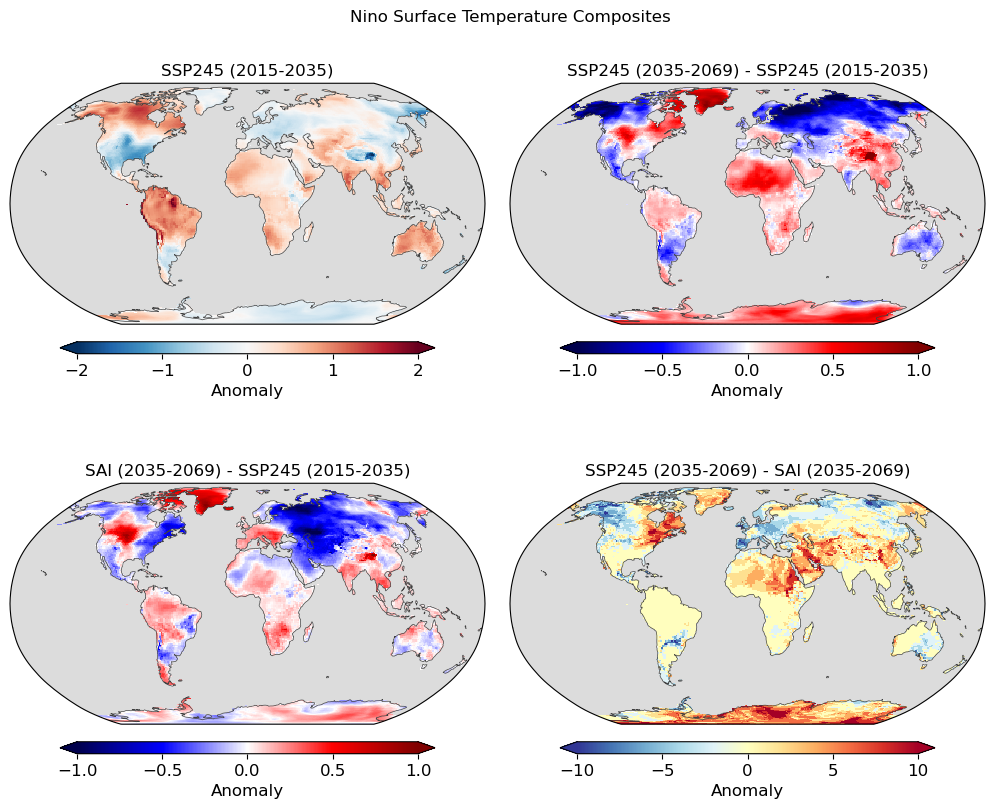

In [12]:
# ---

fig = plt.figure(figsize=(10,8))
fig.suptitle('Nino Surface Temperature Composites', fontsize=12)

# ---

ax1 = plt.axes([0.0, 0.5, 0.475, 0.475], projection=ccrs.Robinson())

cs1 = ax1.pcolormesh(lons, lats, arise_ctl_ts_nino_vals, 
               shading='auto', vmin=-2, vmax=2, cmap='RdBu_r',
               transform=cartopy.crs.PlateCarree())

ax1.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax1.set_title('SSP245 (2015-2035)', fontsize=12)
ax1.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.05, 0.55, 0.375, 0.015])

cbar = fig.colorbar(cs1, cax=cbar_ax, ticks=[-2,-1,0,1,2], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly', fontsize=12)

# ---

ax2 = plt.axes([0.5, 0.5, 0.475, 0.475], projection=ccrs.Robinson())

cs2 = ax2.pcolormesh(lons, lats, waccm_sai_ts_nino_vals - arise_ctl_ts_nino_vals, 
               shading='auto', vmin=-1, vmax=1, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax2.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax2.set_title('SSP245 (2035-2069) - SSP245 (2015-2035)', fontsize=12)
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.55, 0.55, 0.375, 0.015])

cbar = fig.colorbar(cs2, cax=cbar_ax, ticks=[-1,-0.5,0,0.5,1], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly', fontsize=12)

# ---

ax3 = plt.axes([0.0, 0.0, 0.475, 0.475], projection=ccrs.Robinson())

cs3 = ax3.pcolormesh(lons, lats, arise_sai_ts_nino_vals - arise_ctl_ts_nino_vals, 
               shading='auto', vmin=-1, vmax=1, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax3.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax3.set_title('SAI (2035-2069) - SSP245 (2015-2035)', fontsize=12)
ax3.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.05, 0.05, 0.375, 0.015])

cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=[-1,-0.5,0,0.5,1], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly', fontsize=12)

# ---

ax4 = plt.axes([0.5, 0.0, 0.475, 0.475], projection=ccrs.Robinson())

cs4 = ax4.pcolormesh(lons, lats, future_diff_nino_vals, 
               shading='auto', vmin=-10, vmax=10, cmap='RdYlBu_r',
               transform=cartopy.crs.PlateCarree())

ax4.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax4.set_title('SSP245 (2035-2069) - SAI (2035-2069)', fontsize=12)
ax4.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.55, 0.05, 0.375, 0.015])

cbar = fig.colorbar(cs4, cax=cbar_ax, ticks=[-10,-5,0,5,10], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly', fontsize=12)

# ---

plt.show()

# ---

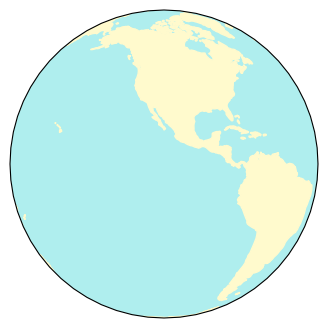

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(4, 4),facecolor="None") #removing the background
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=10.0, globe=None))
#ax.coastlines(resolution='110m')
ax.patch.set_facecolor(color='paleturquoise')
ax.add_feature(cartopy.feature.LAND, color='lemonchiffon')
#ax.background.set_visible(False)
plt.savefig('northamerica.png', dpi=1200)

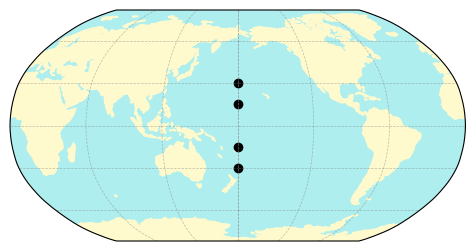

In [67]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


# The projection keyword determines how the plot will look
plt.figure(figsize=(6, 3),facecolor="None")
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180.0, globe=None))#PlateCarree())
ax.set_global()
#ax.coastlines()
ax.patch.set_facecolor(color='paleturquoise')
ax.add_feature(cartopy.feature.LAND, color='lemonchiffon')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

first_lon, first_lat = 180, 15
second_lon, second_lat = 180, -15
third_lon, third_lat = 180, 30
fourth_lon, fourth_lat = 180, -30

plt.plot([first_lon], [first_lat],
         color='black', marker='o',
         transform=ccrs.Geodetic(),
         )
plt.plot([second_lon], [second_lat],
        color='black', marker='o',
        transform=ccrs.Geodetic(),
        )
plt.plot([third_lon], [third_lat],
        color='black', marker='o',
        transform=ccrs.Geodetic(),
        )
plt.plot([fourth_lon], [fourth_lat],
        color='black', marker='o',
        transform=ccrs.Geodetic(),
        )

plt.savefig('latsandlons.png', dpi=1200)

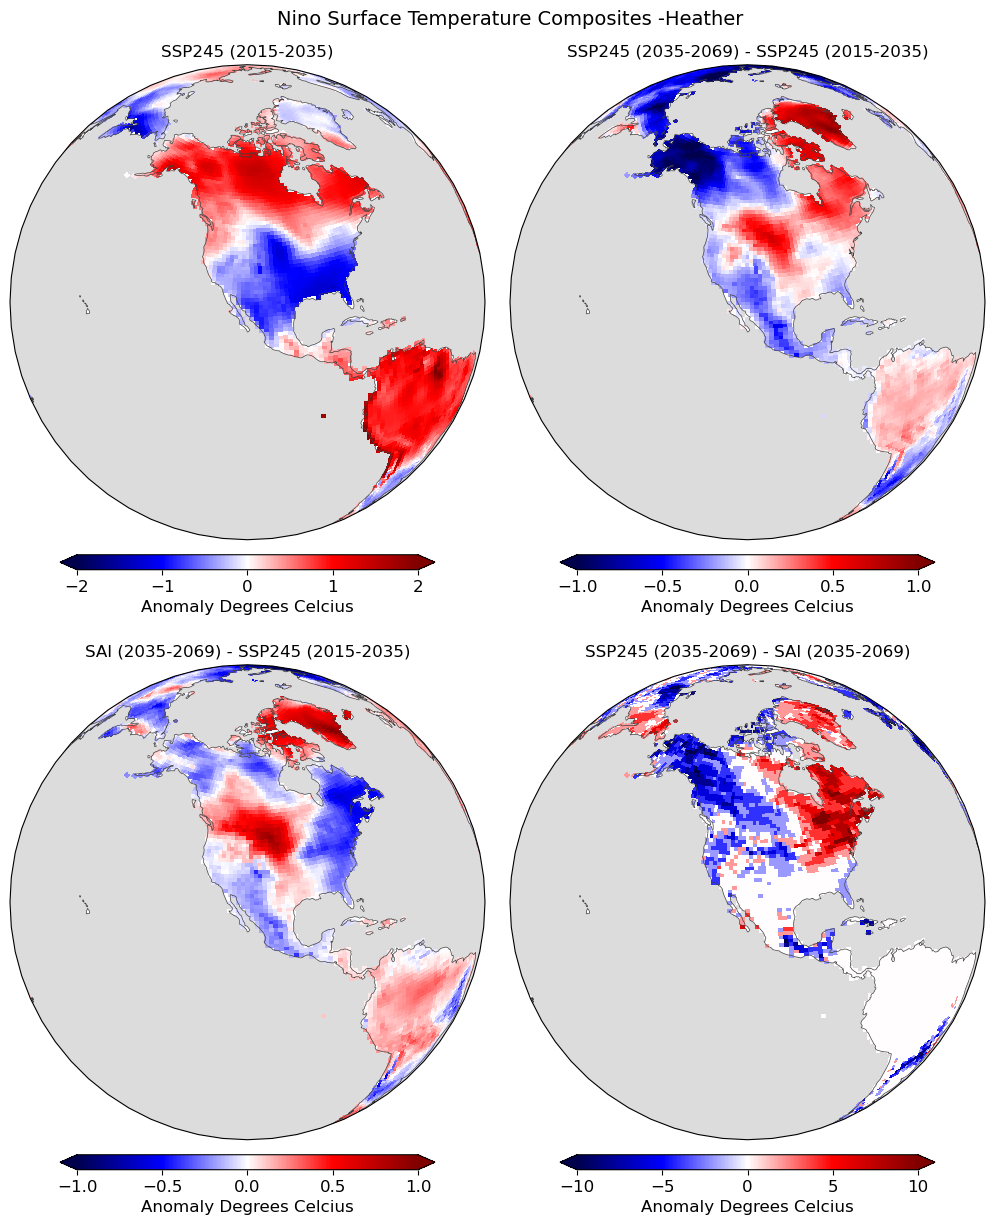

In [19]:
##Heather's Code
# ---

fig = plt.figure(figsize=(10,10))
fig.suptitle('Nino Surface Temperature Composites -Heather', fontsize=14)

# ---

ax1 = plt.axes([0.0, 0.45, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs1 = ax1.pcolormesh(arise_ctl_ts_nino.lon, arise_ctl_ts_nino.lat, arise_ctl_ts_nino_vals, 
#               #shading='auto', vmin=-2, vmax=2, cmap='RdBu_r',
               shading='auto', vmin=-2, vmax=2, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax1.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax1.set_title('SSP245 (2015-2035)', fontsize=12)
ax1.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.05, 0.42, 0.375, 0.015])

cbar = fig.colorbar(cs1, cax=cbar_ax, ticks=[-2.0,-1.0,0.0,1.0,2.0], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)


# ---

ax2 = plt.axes([0.5, 0.45, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs2 = ax2.pcolormesh(lons, lats, waccm_sai_ts_nino_vals - arise_ctl_ts_nino_vals, 
               shading='auto', vmin=-1, vmax=1, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax2.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax2.set_title('SSP245 (2035-2069) - SSP245 (2015-2035)', fontsize=12)
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.55, 0.42, 0.375, 0.015])


cbar = fig.colorbar(cs2, cax=cbar_ax, ticks=[-1.0,-0.5,0.0,0.5,1.0], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)

# ---

ax3 = plt.axes([0.0, -0.15, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs3 = ax3.pcolormesh(lons, lats, arise_sai_ts_nino_vals - arise_ctl_ts_nino_vals, 
               #shading='auto', vmin=-1, vmax=1, cmap='seismic',
               shading='auto', vmin=-1, vmax=1, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax3.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax3.set_title('SAI (2035-2069) - SSP245 (2015-2035)', fontsize=12)
ax3.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.05, -0.18, 0.375, 0.015])

cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=[-1.0,-0.5,0.0,0.5,1.0], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)

# ---

ax4 = plt.axes([0.5, -0.15, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs4 = ax4.pcolormesh(lons, lats, future_diff_nino_vals, 
               #shading='auto', vmin=-10, vmax=10, cmap='RdYlBu_r',
               shading='auto', vmin=-10, vmax=10, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax4.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax4.set_title('SSP245 (2035-2069) - SAI (2035-2069)', fontsize=12)
ax4.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.55, -0.18, 0.375, 0.015])

cbar = fig.colorbar(cs4, cax=cbar_ax, ticks=[-10,-5,0,5,10], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)

# ---

plt.show()

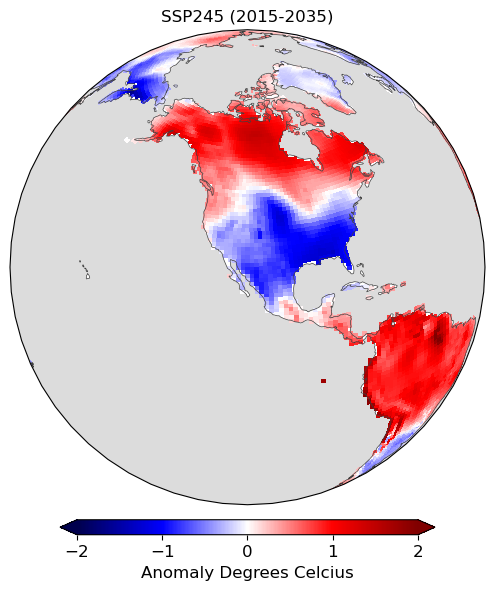

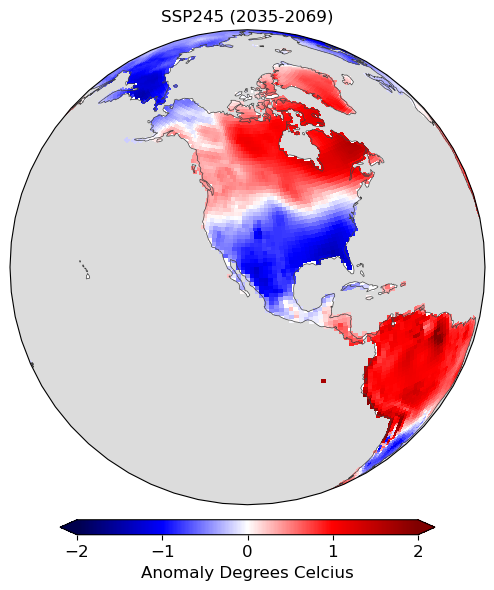

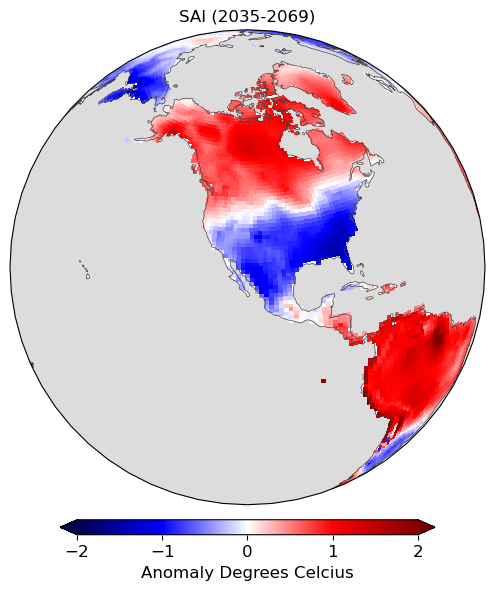

In [22]:
##Heather's Code (new graphs just showing the temperatures)
# ---

fig = plt.figure(figsize=(10,10))
#fig.suptitle('Nino Surface Temperatures', fontsize=14)

# ---

ax1 = plt.axes([0.0, 0.45, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs1 = ax1.pcolormesh(arise_ctl_ts_nino.lon, arise_ctl_ts_nino.lat, arise_ctl_ts_nino_vals, 
#               #shading='auto', vmin=-2, vmax=2, cmap='RdBu_r',
               shading='auto', vmin=-2, vmax=2, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax1.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax1.set_title('SSP245 (2015-2035)', fontsize=12)
ax1.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.05, 0.42, 0.375, 0.015])

cbar = fig.colorbar(cs1, cax=cbar_ax, ticks=[-2.0,-1.0,0.0,1.0,2.0], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)
plt.show()

# ---
fig = plt.figure(figsize=(10,10))
ax2 = plt.axes([0.5, 0.45, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs2 = ax2.pcolormesh(lons, lats, waccm_sai_ts_nino_vals, 
               shading='auto', vmin=-2, vmax=2, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax2.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax2.set_title('SSP245 (2035-2069)', fontsize=12)
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.55, 0.42, 0.375, 0.015])


cbar = fig.colorbar(cs2, cax=cbar_ax, ticks=[-2.0,-1.0,0.0,1.0,2.0], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)
plt.show()

# ---
fig = plt.figure(figsize=(10,10))
ax3 = plt.axes([0.0, -0.15, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs3 = ax3.pcolormesh(lons, lats, arise_sai_ts_nino_vals, 
               #shading='auto', vmin=-1, vmax=1, cmap='seismic',
               shading='auto', vmin=-2, vmax=2, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax3.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax3.set_title('SAI (2035-2069)', fontsize=12)
ax3.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.05, -0.18, 0.375, 0.015])

cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=[-2.0,-1.0,0.0,1.0,2.0], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)
plt.show()

# ---


# ---

#plt.show()

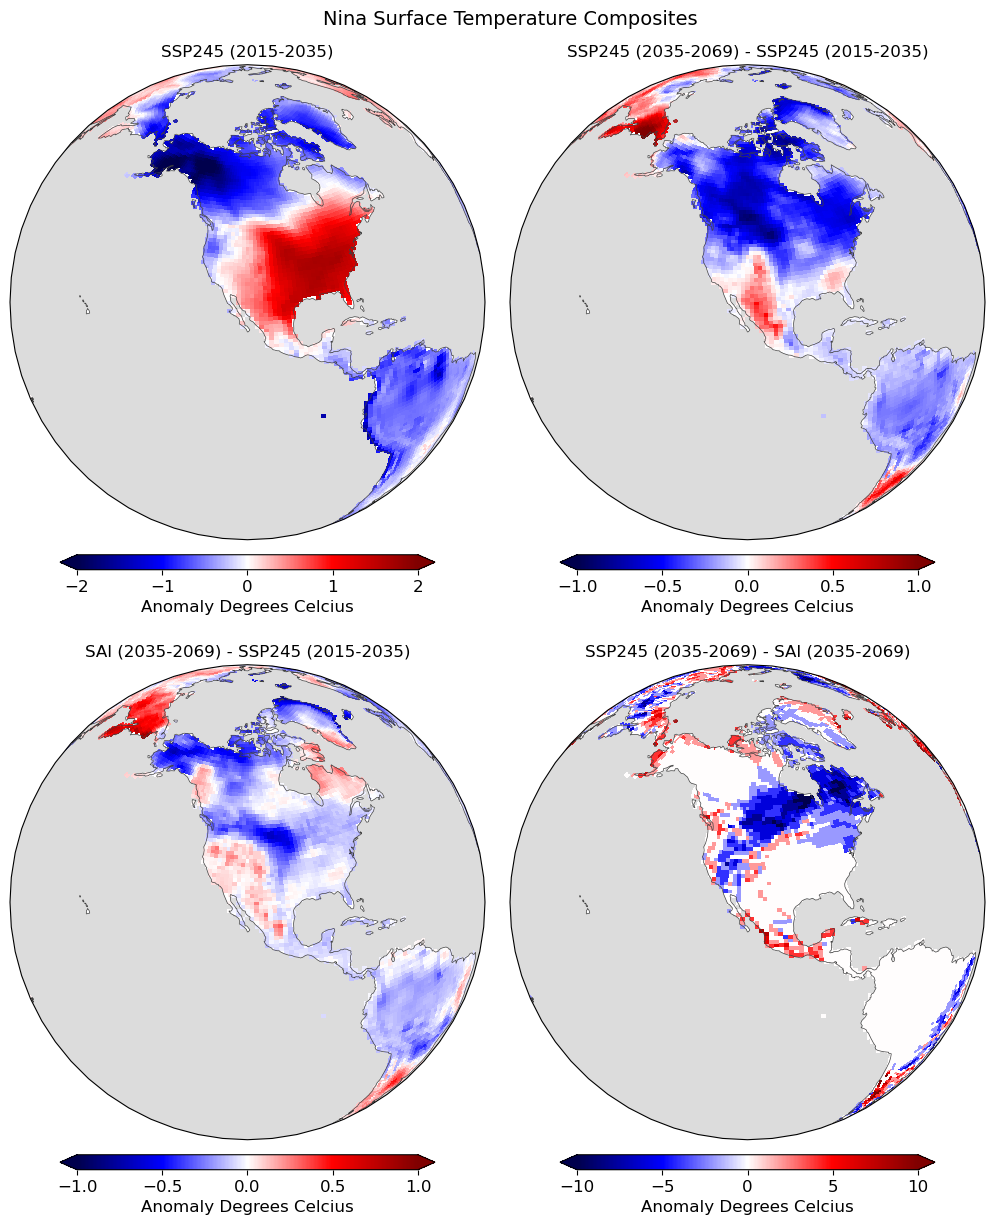

In [12]:
# --- Heather Nina

fig = plt.figure(figsize=(10,10))
fig.suptitle('Nina Surface Temperature Composites', fontsize=14)

# ---

ax1 = plt.axes([0.0, 0.45, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs1 = ax1.pcolormesh(lons, lats, arise_ctl_ts_nina_vals, 
               shading='auto', vmin=-2, vmax=2, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax1.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax1.set_title('SSP245 (2015-2035)', fontsize=12)
ax1.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.05, 0.42, 0.375, 0.015])

cbar = fig.colorbar(cs1, cax=cbar_ax, ticks=[-2,-1,0,1,2], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)

# ---

ax2 = plt.axes([0.5, 0.45, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs2 = ax2.pcolormesh(lons, lats, waccm_sai_ts_nina_vals - arise_ctl_ts_nina_vals, 
               shading='auto', vmin=-1, vmax=1, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax2.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax2.set_title('SSP245 (2035-2069) - SSP245 (2015-2035)', fontsize=12)
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.55, 0.42, 0.375, 0.015])

cbar = fig.colorbar(cs2, cax=cbar_ax, ticks=[-1,-0.5,0,0.5,1], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)

# ---

ax3 = plt.axes([0.0, -0.15, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs3 = ax3.pcolormesh(lons, lats, arise_sai_ts_nina_vals - arise_ctl_ts_nina_vals, 
               shading='auto', vmin=-1, vmax=1, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax3.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax3.set_title('SAI (2035-2069) - SSP245 (2015-2035)', fontsize=12)
ax3.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.05, -0.18, 0.375, 0.015])

cbar = fig.colorbar(cs3, cax=cbar_ax, ticks=[-1,-0.5,0,0.5,1], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)

# ---

ax4 = plt.axes([0.5, -0.15, 0.475, 0.475], projection=ccrs.Orthographic(central_longitude=250.0, central_latitude=30.0, globe=None))

cs4 = ax4.pcolormesh(lons, lats, future_diff_nina_vals, 
               shading='auto', vmin=-10, vmax=10, cmap='seismic',
               transform=cartopy.crs.PlateCarree())

ax4.coastlines(resolution='110m', color='0.25', linewidth=0.5)
ax4.set_title('SSP245 (2035-2069) - SAI (2035-2069)', fontsize=12)
ax4.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# -

cbar_ax = fig.add_axes([0.55, -0.18, 0.375, 0.015])

cbar = fig.colorbar(cs4, cax=cbar_ax, ticks=[-10,-5,0,5,10], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Anomaly Degrees Celcius', fontsize=12)

# ---
plt.savefig("nina.png")
plt.show()


# ---

In [2]:
# Loading in the CA time series files

files_SAIJET = [
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.001.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.002.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.003.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.004.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.005.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.006.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.007.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.008.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.009.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.010.PSL.nc'
]

files_SSPJET1 = [
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.001.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.002.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.003.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.004.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.005.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.006.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.007.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.008.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.009.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.010.PSL.nc'
]

files_SSPJET2=[
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.001.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.002.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.003.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.004.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.005.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.006.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.007.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.008.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.009.PSL.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.010.PSL.nc'
]

files_PRECIP_SAI=[
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.001.PRECT.nc', 
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.002.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.003.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.004.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.005.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.006.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.007.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.008.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.009.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.010.PRECT.nc'
]

files_PRECIP_SSP1=[
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.001.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.002.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.003.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.004.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.005.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.006.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.007.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.008.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.009.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.010.PRECT.nc'
]

files_PRECIP_SSP2=[
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.001.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.002.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.003.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.004.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.005.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.006.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.007.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.008.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.009.PRECT.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.010.PRECT.nc'
]

files_TEMPSAI=[
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.001.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.002.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.003.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.004.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.005.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.006.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.007.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.008.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.009.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.010.TS.nc'
]   

files_TEMPSSP1=[
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.001.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.002.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.003.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.004.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.005.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.006.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.007.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.008.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.009.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part1.010.TS.nc'
]    
    
files_TEMPSSP2=[
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.001.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.002.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.003.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.004.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.005.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.006.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.007.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.008.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.009.TS.nc',
    'C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_ssp_part2.010.TS.nc'
] 

In [3]:
##opening the jet ssp parts 1 and 2
ds11 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.001.PSL.nc')
ds21 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.001.PSL.nc')
ds12 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.002.PSL.nc')
ds22 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.002.PSL.nc')
ds13 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.003.PSL.nc')
ds23 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.003.PSL.nc')
ds14 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.004.PSL.nc')
ds24 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.004.PSL.nc')
ds15 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.005.PSL.nc')
ds25 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.005.PSL.nc')
ds16 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.006.PSL.nc')
ds26 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.006.PSL.nc')
ds17 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.007.PSL.nc')
ds27 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.007.PSL.nc')
ds18 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.008.PSL.nc')
ds28 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.008.PSL.nc')
ds19 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.009.PSL.nc')
ds29 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.009.PSL.nc')
ds110 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part1.010.PSL.nc')
ds210 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_ssp_part2.010.PSL.nc')
#dsmerged = xr.merge([files_SSPJET1,files_SSPJET2])



In [4]:
##opening the precip_ssp parts 1 and 2
p_ssp11 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.001.PRECT.nc')
p_ssp21 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.001.PRECT.nc')
p_ssp12 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.002.PRECT.nc')
p_ssp22 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.002.PRECT.nc')
p_ssp13 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.003.PRECT.nc')
p_ssp23 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.003.PRECT.nc')
p_ssp14 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.004.PRECT.nc')
p_ssp24 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.004.PRECT.nc')
p_ssp15 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.005.PRECT.nc')
p_ssp25 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.005.PRECT.nc')
p_ssp16 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.006.PRECT.nc')
p_ssp26 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.006.PRECT.nc')
p_ssp17 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.007.PRECT.nc')
p_ssp27 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.007.PRECT.nc')
p_ssp18 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.008.PRECT.nc')
p_ssp28 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.008.PRECT.nc')
p_ssp19 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.009.PRECT.nc')
p_ssp29 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.009.PRECT.nc')
p_ssp110 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part1.010.PRECT.nc')
p_ssp210 = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_ssp_part2.010.PRECT.nc')

In [5]:
##piecing together the jet ssp parts 1 and 2
ds_psl = xr.concat([ds11, ds21], dim='time')
ds_ps2 = xr.concat([ds12, ds22], dim='time')
ds_ps3 = xr.concat([ds13, ds23], dim='time')
ds_ps4 = xr.concat([ds14, ds24], dim='time')
ds_ps5 = xr.concat([ds15, ds25], dim='time')
ds_ps6 = xr.concat([ds16, ds26], dim='time')
ds_ps7 = xr.concat([ds17, ds27], dim='time')
ds_ps8 = xr.concat([ds18, ds28], dim='time')
ds_ps9 = xr.concat([ds19, ds29], dim='time')
ds_ps10 = xr.concat([ds110, ds210], dim='time')

In [6]:
#this is for the jet
ds_psl['PSL']

<xarray.DataArray 'PSL' (time: 1032)>
array([102207.664, 102542.09 , 101892.58 , ..., 101911.016, 102309.02 ,
       102481.76 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-02-01 2015-03-01 ... 2101-01-01

In [7]:
##piecing together the precip ssp parts 1 and 2
p_ssp_1 = xr.concat([p_ssp11, p_ssp21], dim='time')
p_ssp_2 = xr.concat([p_ssp12, p_ssp22], dim='time')
p_ssp_3 = xr.concat([p_ssp13, p_ssp23], dim='time')
p_ssp_4 = xr.concat([p_ssp14, p_ssp24], dim='time')
p_ssp_5 = xr.concat([p_ssp15, p_ssp25], dim='time')
p_ssp_6 = xr.concat([p_ssp16, p_ssp26], dim='time')
p_ssp_7 = xr.concat([p_ssp17, p_ssp27], dim='time')
p_ssp_8 = xr.concat([p_ssp18, p_ssp28], dim='time')
p_ssp_9 = xr.concat([p_ssp19, p_ssp29], dim='time')
p_ssp_10 = xr.concat([p_ssp110, p_ssp210], dim='time')

In [8]:
##slicing the time for current climate (jet)
ds_psl_new = ds_psl.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
ds_ps2_new = ds_ps2.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
ds_ps3_new = ds_ps3.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
ds_ps4_new = ds_ps4.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
ds_ps5_new = ds_ps5.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
ds_ps6_new = ds_ps6.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
ds_ps7_new = ds_ps7.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
ds_ps8_new = ds_ps8.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
ds_ps9_new = ds_ps9.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
ds_ps10_new = ds_ps10.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))


In [10]:
ds_psl_new

<xarray.Dataset>
Dimensions:  (time: 241)
Coordinates:
  * time     (time) datetime64[ns] 2015-02-01 2015-03-01 ... 2035-02-01
Data variables:
    PSL      (time) float32 1.022e+05 1.025e+05 ... 1.017e+05 1.017e+05

In [9]:
##slicing the time for current climate precip ssp
p_ssp_1_new = p_ssp_1.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
p_ssp_2_new = p_ssp_2.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
p_ssp_3_new = p_ssp_3.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
p_ssp_4_new = p_ssp_4.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
p_ssp_5_new = p_ssp_5.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
p_ssp_6_new = p_ssp_6.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
p_ssp_7_new = p_ssp_7.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
p_ssp_8_new = p_ssp_8.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
p_ssp_9_new = p_ssp_9.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))
p_ssp_10_new = p_ssp_10.sel(time=slice('2015-02-01T00:00:00.000000000','2035-02-01T00:00:00.000000000'))


In [10]:
enso = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData002/ARISEData/ARISECTL001.cvdp_data.2015-2035.nc',decode_times=False)

In [14]:
enso

<xarray.Dataset>
Dimensions:                               (TIME: 21, lat: 192, lon: 288, ncurves: 4, frequency: 126, time: 252, j: 384, i: 320, j2: 384, i2: 320, longitude: 129, time_mon3: 49, time_mon1: 29, time_mon2: 12, period: 96)
Coordinates: (12/15)
  * TIME                                  (TIME) int32 2015 2016 ... 2034 2035
  * frequency                             (frequency) float32 0.003968 ... 0.5
  * lat                                   (lat) float64 -90.0 -89.06 ... 90.0
    lat2d_ice_nh                          (j, i) float32 ...
    lat2d_ice_sh                          (j2, i2) float32 ...
  * lon                                   (lon) float64 0.0 1.25 ... 357.5 358.8
    ...                                    ...
  * ncurves                               (ncurves) int32 0 1 2 3
  * period                                (period) float32 0.08609 ... 20.8
  * time                                  (time) float32 0.0 1.0 ... 250.0 251.0
  * time_mon1                             (time_mon1) int32 0 1 2 3 ... 26 27 28
  * time_mon2                             (time_mon2) int32 0 1 2 3 ... 9 10 11
  * time_mon3                             (time_mon3) int32 0 1 2 3 ... 46 47 48
Dimensions without coordinates: j, i, j2, i2
Data variables: (12/394)
    amv_pattern_lowpass_mon               (lat, lon) float32 ...
    amv_pattern_mon                       (lat, lon) float32 ...
    amv_pr_regression_lowpass_mon         (lat, lon) float32 ...
    amv_pr_regression_mon                 (lat, lon) float32 ...
    amv_prime_pattern_lowpass_mon         (lat, lon) float32 ...
    amv_prime_pattern_mon                 (lat, lon) float32 ...
    ...                                    ...
    tas_trends_jas                        (lat, lon) float32 ...
    tas_trends_jfm                        (lat, lon) float32 ...
    tas_trends_jja                        (lat, lon) float32 ...
    tas_trends_mam                        (lat, lon) float32 ...
    tas_trends_son                        (lat, lon) float32 ...
    tropical_indian_ocean                 (time) float32 ...
Attributes:
    source:       NCAR Climate Analysis Section's Climate Variability Diagnos...
    notes:        Data from ARISECTL001 Ensemble Mean from 2015-2035
    climatology:  2015-2035 climatology removed prior to all calculations (ot...
    Conventions:  CF-1.6
    history:      Mon Sep 19 23:20:03 2022: ncks -O ./output/ARISECTL001.cvdp...
    NCO:          "4.5.2"

In [11]:
enso['nino34']

<xarray.DataArray 'nino34' (time: 252)>
array([-1.046472, -0.605994, -0.226569, ..., -1.55817 , -1.529478, -1.588619],
      dtype=float32)
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 248.0 249.0 250.0 251.0
Attributes:
    units:         C
    long_name:     nino3.4 timeseries (monthly)
    comment_cvdp:  area average domain (-5:5N, 190:240E)

In [12]:
enso_new = enso['nino34']

In [13]:
enso_new = enso_new[1:]
enso_new = enso_new[:-10]
enso_new

<xarray.DataArray 'nino34' (time: 241)>
array([-0.605994, -0.226569,  0.209138, ...,  3.855347,  3.602753,  3.125007],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 ... 238.0 239.0 240.0 241.0
Attributes:
    units:         C
    long_name:     nino3.4 timeseries (monthly)
    comment_cvdp:  area average domain (-5:5N, 190:240E)

In [15]:
jet = ds_psl_new['PSL'] #ssp_jet_current_climate

precip = p_ssp_1_new['PRECT'] #ssp_precip_current_climate
enso_2 = enso_new #el nino current climate

Text(0.5, 1.0, 'el nino')

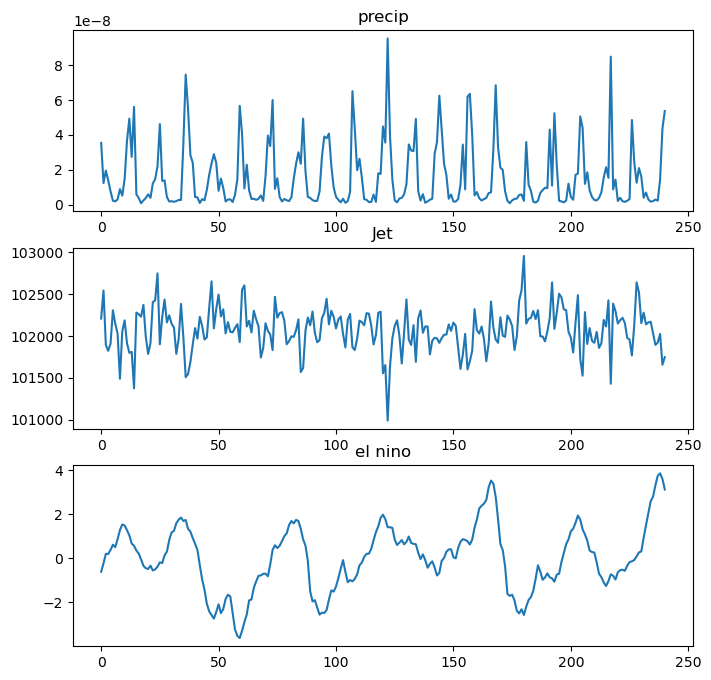

In [16]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(311)
plt.plot(precip)
plt.title('precip')
plt.subplot(312)
plt.plot(jet)
plt.title('Jet')
plt.subplot(313)
plt.plot(enso_2)
plt.title('el nino')

In [17]:
ENSO = (enso_2 - np.mean(enso_2.data))/np.std(enso_2.data)
JET = (jet - np.mean(jet.data))/np.std(jet.data)
CA = (precip - np.mean(precip.data))/np.std(precip.data)

In [18]:
ENSO_detrend = signal.detrend(ENSO.data)
JET = signal.detrend(JET.data)
CA = signal.detrend(CA.data)

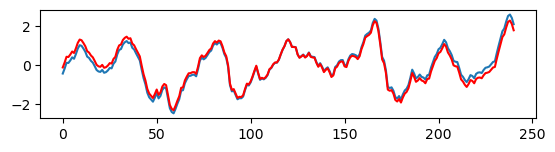

In [19]:
plt.subplot(311)
plt.plot(ENSO)
plt.plot(ENSO_detrend, 'r')
plt.show()

In [20]:
import statsmodels.api as sm

In [21]:
#================================================================
# Determine the effect of ENSO on CA conditioned on Jet
#================================================================

X = np.stack([ENSO_detrend, JET]).T

Y = CA[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_enso_ca_cond_jet = results.params[0]
ce_jet_ca = results.params[1]

print("The regression coeff of ENSO on CA conditioned on Jet is ", round(ce_enso_ca_cond_jet,2))
print("The regression coeff. of Jet on CA is ", round(ce_jet_ca,2))

The regression coeff of ENSO on CA conditioned on Jet is  -0.08
The regression coeff. of Jet on CA is  -0.48


In [22]:
#================================================================
# Determine the causal effect of ENSO on CA 
#================================================================
X =  ENSO[:]
Y = CA[:]

model = sm.OLS(Y,X.values)
results = model.fit()

ce_enso_ca = results.params[0]

print("The causal effect of ENSO on CA is ", round(ce_enso_ca,2))

The causal effect of ENSO on CA is  0.09


In [23]:
#================================================================
# Determine the causal effect of ENSO on Jet
#================================================================
X =  ENSO[:]
Y = JET[:]

model = sm.OLS(Y,X.values)
results = model.fit()

ce_enso_jet = results.params[0]

print("The causal effect of ENSO on Jet is ", round(ce_enso_jet,2))

The causal effect of ENSO on Jet is  -0.35


In [24]:
#================================================================
# Determine the causal effect of Jet on CA
#================================================================
X =  JET[:]
Y = CA[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_jet_ca = results.params[0]

print("The causal effect of Jet on CA is ", round(ce_jet_ca,2))

The causal effect of Jet on CA is  -0.45


the code below is for the future SSP2-4.5 emission scenario without intervention 

In [25]:
##piecing together the jet ssp parts 1 and 2 for the future
ds_psl_fut = xr.concat([ds11, ds21], dim='time')
ds_ps2_fut = xr.concat([ds12, ds22], dim='time')
ds_ps3_fut = xr.concat([ds13, ds23], dim='time')
ds_ps4_fut = xr.concat([ds14, ds24], dim='time')
ds_ps5_fut = xr.concat([ds15, ds25], dim='time')
ds_ps6_fut = xr.concat([ds16, ds26], dim='time')
ds_ps7_fut = xr.concat([ds17, ds27], dim='time')
ds_ps8_fut = xr.concat([ds18, ds28], dim='time')
ds_ps9_fut = xr.concat([ds19, ds29], dim='time')
ds_ps10_fut = xr.concat([ds110, ds210], dim='time')

In [26]:
##slicing the time for future climate for the jet
ds_psl_fut_new = ds_psl_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
ds_ps2_fut_new = ds_ps2_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
ds_ps3_fut_new = ds_ps3_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
ds_ps4_fut_new = ds_ps4_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
ds_ps5_fut_new = ds_ps5_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
ds_ps6_fut_new = ds_ps6_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
ds_ps7_fut_new = ds_ps7_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
ds_ps8_fut_new = ds_ps8_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
ds_ps9_fut_new= ds_ps9_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
ds_ps10_fut_new = ds_ps10_fut.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))

In [27]:
ds_psl_fut_new

<xarray.Dataset>
Dimensions:  (time: 409)
Coordinates:
  * time     (time) datetime64[ns] 2035-02-01 2035-03-01 ... 2069-02-01
Data variables:
    PSL      (time) float32 1.017e+05 1.017e+05 ... 1.019e+05 1.024e+05

In [28]:
##slicing the time for future climate precip ssp
p_ssp_1_fut = p_ssp_1.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
p_ssp_2_fut = p_ssp_2.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
p_ssp_3_fut = p_ssp_3.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
p_ssp_4_fut = p_ssp_4.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
p_ssp_5_fut = p_ssp_5.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
p_ssp_6_fut = p_ssp_6.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
p_ssp_7_fut = p_ssp_7.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
p_ssp_8_fut = p_ssp_8.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
p_ssp_9_fut = p_ssp_9.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))
p_ssp_10_fut = p_ssp_10.sel(time=slice('2035-02-01T00:00:00.000000000','2069-02-01T00:00:00.000000000'))

In [29]:
enso_fut = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/WACCM245001.cvdp_data.2035-2069.nc', decode_times=False)
enso_fut_new = enso_fut['nino34']
enso_fut_new = enso_fut_new[1:]
enso_fut_new = enso_fut_new[:-10]
enso_fut_new

<xarray.DataArray 'nino34' (time: 409)>
array([ 2.097795,  1.404112,  0.891699, ..., -2.492724, -2.465081, -1.920684],
      dtype=float32)
Coordinates:
  * time     (time) float32 1.0 2.0 3.0 4.0 5.0 ... 406.0 407.0 408.0 409.0
Attributes:
    units:         C
    long_name:     nino3.4 timeseries (monthly)
    comment_cvdp:  area average domain (-5:5N, 190:240E)

In [30]:
jet_fut = ds_psl_fut_new ['PSL'] #ssp_jet_future_climate
precip_fut = p_ssp_1_fut['PRECT'] #ssp_precip_future_climate
enso_fut_ssp = enso_fut_new #el nino future climate

Text(0.5, 1.0, 'el nino')

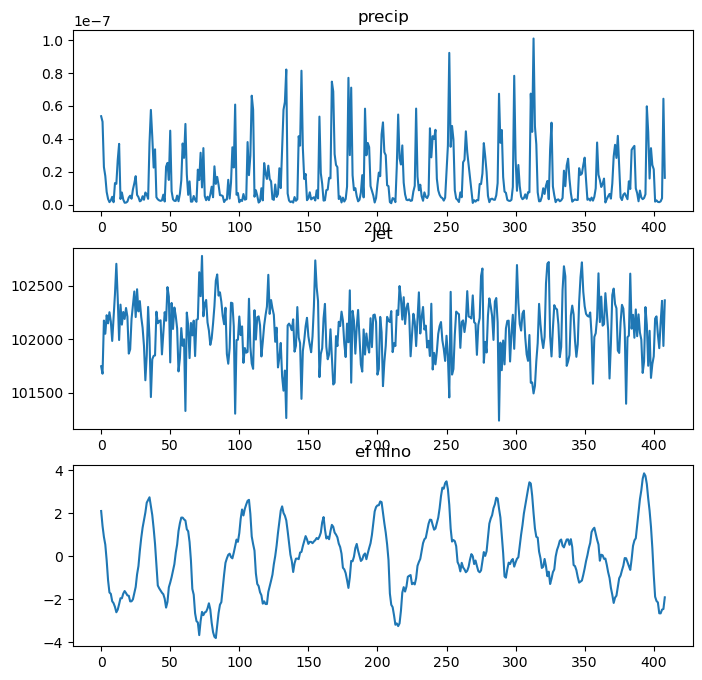

In [31]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(311)
plt.plot(precip_fut)
plt.title('precip')
plt.subplot(312)
plt.plot(jet_fut)
plt.title('Jet')
plt.subplot(313)
plt.plot(enso_fut_ssp)
plt.title('el nino')

In [32]:
ENSO = (enso_fut_ssp - np.mean(enso_fut_ssp.data))/np.std(enso_fut_ssp.data)
JET = (jet_fut - np.mean(jet_fut.data))/np.std(jet_fut.data)
CA = (precip_fut - np.mean(precip_fut.data))/np.std(precip_fut.data)

In [33]:
ENSO_detrend = signal.detrend(ENSO.data)
JET = signal.detrend(JET.data)
CA = signal.detrend(CA.data)

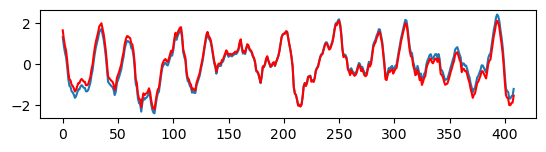

In [34]:
plt.subplot(311)
plt.plot(ENSO)
plt.plot(ENSO_detrend, 'r')
plt.show()

In [35]:
import statsmodels.api as sm

In [36]:
#================================================================
# Determine the effect of ENSO on CA conditioned on Jet
#================================================================

X = np.stack([ENSO_detrend, JET]).T

Y = CA[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_enso_ca_cond_jet = results.params[0]
ce_jet_ca = results.params[1]

print("The regression coeff of ENSO on CA conditioned on Jet is ", round(ce_enso_ca_cond_jet,2))
print("The regression coeff. of Jet on CA is ", round(ce_jet_ca,2))

The regression coeff of ENSO on CA conditioned on Jet is  -0.01
The regression coeff. of Jet on CA is  -0.44


In [37]:
#================================================================
# Determine the causal effect of ENSO on CA 
#================================================================
X =  ENSO[:]
Y = CA[:]

model = sm.OLS(Y,X.values)
results = model.fit()

ce_enso_ca = results.params[0]

print("The causal effect of ENSO on CA is ", round(ce_enso_ca,2))

The causal effect of ENSO on CA is  0.17


In [38]:
#================================================================
# Determine the causal effect of ENSO on Jet
#================================================================
X =  ENSO[:]
Y = JET[:]

model = sm.OLS(Y,X.values)
results = model.fit()

ce_enso_jet = results.params[0]

print("The causal effect of ENSO on Jet is ", round(ce_enso_jet,2))

The causal effect of ENSO on Jet is  -0.4


In [39]:
#================================================================
# Determine the causal effect of Jet on CA
#================================================================
X =  JET[:]
Y = CA[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_jet_ca = results.params[0]

print("The causal effect of Jet on CA is ", round(ce_jet_ca,2))

The causal effect of Jet on CA is  -0.44


The code below is calculating the coefficients for the future SAI scenario

In [56]:
jet_SAI = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_jet_sai.001.PSL.nc')
precip_SAI = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_precip_sai.001.PRECT.nc')
#temp_SAI = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/causality-project/causality-sai-data/cali_temp_sai.001.TS.nc')
temp_SAI = xr.open_dataset('C:/Users/Heather/Documents/Fall 2022/SeniorResearch/Data/ARISEData001/ARISEData/ARISESAI001.cvdp_data.2035-2069.nc', decode_times=False)

In [59]:
jet_SAI_fut = jet_SAI['PSL'] #jet_SAI
precip_SAI_fut = precip_SAI['PRECT'] #precip_SAI
enso_SAI_fut = temp_SAI['nino34'] #ENSO_SAI

Text(0.5, 1.0, 'el nino')

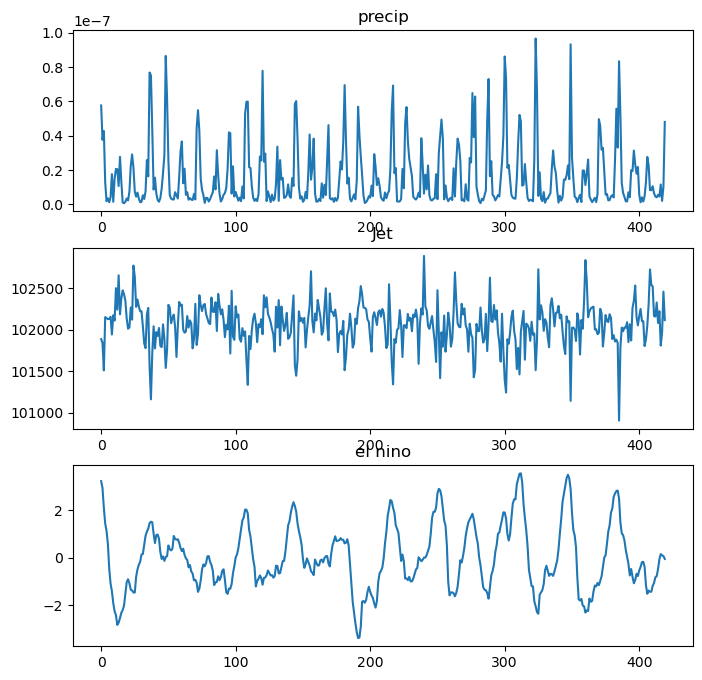

In [60]:
fig = plt.figure(figsize=(8, 8))
plt.subplot(311)
plt.plot(precip_SAI_fut)
plt.title('precip')
plt.subplot(312)
plt.plot(jet_SAI_fut)
plt.title('Jet')
plt.subplot(313)
plt.plot(enso_SAI_fut)
plt.title('el nino')

In [61]:
ENSO = (enso_SAI_fut - np.mean(enso_SAI_fut.data))/np.std(enso_SAI_fut.data)
JET = (jet_SAI_fut - np.mean(jet_SAI_fut.data))/np.std(jet_SAI_fut.data)
CA = (precip_SAI_fut - np.mean(precip_SAI_fut.data))/np.std(precip_SAI_fut.data)

In [62]:
ENSO_detrend = signal.detrend(ENSO.data)
JET = signal.detrend(JET.data)
CA = signal.detrend(CA.data)

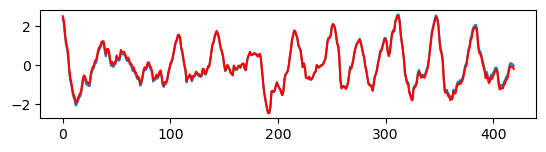

In [63]:
plt.subplot(311)
plt.plot(ENSO)
plt.plot(ENSO_detrend, 'r')
plt.show()

In [64]:
#================================================================
# Determine the effect of ENSO on CA conditioned on Jet
#================================================================

X = np.stack([ENSO_detrend, JET]).T

Y = CA[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_enso_ca_cond_jet = results.params[0]
ce_jet_ca = results.params[1]

print("The regression coeff of ENSO on CA conditioned on Jet is ", round(ce_enso_ca_cond_jet,2))
print("The regression coeff. of Jet on CA is ", round(ce_jet_ca,2))

The regression coeff of ENSO on CA conditioned on Jet is  -0.03
The regression coeff. of Jet on CA is  -0.47


In [65]:
#================================================================
# Determine the causal effect of ENSO on CA 
#================================================================
X =  ENSO[:]
Y = CA[:]

model = sm.OLS(Y,X.values)
results = model.fit()

ce_enso_ca = results.params[0]

print("The causal effect of ENSO on CA is ", round(ce_enso_ca,2))

The causal effect of ENSO on CA is  0.17


In [66]:
#================================================================
# Determine the causal effect of ENSO on Jet
#================================================================
X =  ENSO[:]
Y = JET[:]

model = sm.OLS(Y,X.values)
results = model.fit()

ce_enso_jet = results.params[0]

print("The causal effect of ENSO on Jet is ", round(ce_enso_jet,2))

The causal effect of ENSO on Jet is  -0.43


In [67]:
#================================================================
# Determine the causal effect of Jet on CA
#================================================================
X =  JET[:]
Y = CA[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_jet_ca = results.params[0]

print("The causal effect of Jet on CA is ", round(ce_jet_ca,2))

The causal effect of Jet on CA is  -0.46
